In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2

In [2]:
include("../../util.j")

colnorm (generic function with 1 method)

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
#using Pkg
#Pkg.add("ProgressMeter");

In [5]:
@load "../data/sim1data.jld"

44-element Array{Symbol,1}:
 Symbol("##1#2")          
 Symbol("##3#5")          
 Symbol("##4#6")          
 Symbol("##7#8")          
 Symbol("#BuildNN")       
 Symbol("#colnorm")       
 Symbol("#getAD")         
 Symbol("#getAD_collapse")
 Symbol("#kfoldperm")     
 :BuildNN                 
 :D                       
 :F                       
 :M                       
 ⋮                        
 :ordx                    
 :p                       
 :q                       
 :Σ                       
 :α                       
 :β                       
 :ν1                      
 :ρ1                      
 :ω                       
 :ω_incp_obs              
 :ω_ord                   
 :ϕ1                      

In [6]:
# priors #
K = 2;
μβ = fill(0.0, p, q); inv_Vr = [[0.0 0.0]; [0.0 0.0]];
μΛ = fill(0.0, K, q); inv_VΛ =[[0.0 0.0]; [0.0 0.0]];
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
ϕU = 300 / sqrt(2); ϕL = 3 / sqrt(2);

# tuning parameters #
RWM_scale = 0.6;                                              # random-walk metropolis step size scale 

In [7]:
# preallocation #

inv_Lβ = [[0.0 0.0]; [0.0 0.0]]; inv_LΛ = [[0.0 0.0]; [0.0 0.0]];

F = Array{Float64,2}(undef, n , 3);                           # preallocate the matrix F
nIndx = length(NN.nnIndx);
A1 = Array{Float64}(undef, nIndx); D1 = Array{Float64}(undef, n);
A2 = Array{Float64}(undef, nIndx); D2 = Array{Float64}(undef, n);
I_A1 = SparseMatrixCSC{Float64,Int64};
I_A2 = SparseMatrixCSC{Float64,Int64}; 
A1_new = Array{Float64}(undef, nIndx); D1_new = Array{Float64}(undef, n);
A2_new = Array{Float64}(undef, nIndx); D2_new = Array{Float64}(undef, n);
I_A1_new = SparseMatrixCSC{Float64,Int64};
I_A2_new = SparseMatrixCSC{Float64,Int64}; 
Ystar = vcat(Y_ord[S, :], inv_Lβ * μβ, inv_LΛ * μΛ);             # will be updated after imputing missing response
Xstar = vcat([X_ord[S, :] fill(0.0, n, K)], [inv_Lβ fill(0.0, p, K)], 
    [fill(0.0, K, p) inv_LΛ]);      
Ψstar = fill(0.0, q, q); νstar = νΣ + n;
μγstar = vcat(μβ, μΛ); Vγstar = fill(0.0, p + K, p + K);
Y_Xm = fill(0.0, n, q); invVγstar = fill(0.0, p + K, p + K);

In [8]:
# precalculation #
v1 = zeros(N); v1[S] .= 1;
v2 = zeros(N); v2[S] .= 1;
index_S = (2^0 * v1 + 2^1 * v2);                              # build index indicating which response are observed
obs_ind = vcat(S, S .+ N);              # index of the observed location for all response among N locations
perm_ind = sortperm(vcat(S, S));                    # the vector of the permutation 

MCMC sampling algorithm
Q1: priors for $\nu_i$ 
Q2: $\phi_i$ may not be consistant, since the order can change 

In [9]:
# Preallocation for MCMC samples and Initalization #
N_sam = 20000;
γ_sam = Array{Float64, 3}(undef, p + K, q, N_sam + 1);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam + 1);
F_sam = Array{Float64, 3}(undef, n, K, N_sam);
A_sam = Array{Float64, 1}(undef, N_sam); # acceptance rate
lh_old = 1; lh_new = 1;     # record the likelihood for updating ranges

ϕ_sam = Array{Float64, 2}(undef, K, N_sam + 1);

γ_sam[:, :, 1] = vcat([[0.0 0.0]; [0.0 0.0]], [[1.0 0.0]; [0.0 1.0]]);
Σ_sam[:, :, 1] = [[0.5 0.1]; [0.1 0.5]];
ϕ_sam[:, 1] = [6, 6];

precond_D = Array{Float64, 1}(undef, K * n);


In [10]:
# for loop for MCMC chain #
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    # Build the matrix D_Sigma_o^{1/2} #
    Dic_diag = Dict(2^0 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][1, 1])), 
        2^1 => sparse(1I, 1, 1) * (1 / sqrt(Σ_sam[:, :, l][2, 2])), 
        (2^0 + 2^1)=> sparse(sqrt(inv(Σ_sam[:, :, l]))));
    invD = blockdiag([Dic_diag[i] for i in index_S if i > 0]...);
                    
    # Build the matrix for the first iteration #
    if l == 1
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[1, l], 0.5, A1, D1);
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[2, l], 0.5, A2, D2);
        I_A1 = sparse(nnIndx_row, nnIndx_col, vcat(-A1, ones(n)));
        I_A2 = sparse(nnIndx_row, nnIndx_col, vcat(-A2, ones(n)));
    end
                    

    # Build Ytilde Xtilde
    Ytilde = vcat(invD * vcat(Y_ord[S, 1] - X_ord[S, :] * γ_sam[1:p, 1, l], 
                            Y_ord[S, 2] - X_ord[S, :] * γ_sam[1:p, 2, l])[perm_ind], zeros(K * n));
    Xtilde = vcat(invD * kron(sparse(transpose(γ_sam[(p + 1):(p + K), :, l])), 
                            sparse(1:N, 1:N, ones(N)))[obs_ind, 
                            vcat(S, S .+ N)][perm_ind, :],
             blockdiag(Diagonal(1 ./ sqrt.(D1)) * I_A1, Diagonal(1 ./ sqrt.(D2)) * I_A2));
                
    # use LSMR to generate sample of F #       
    nsam = length(Ytilde);
    Precond_D = colnorm(Xtilde);
    F_sam[:, :, l] = reshape(Diagonal(1 ./ Precond_D) * lsmr(Xtilde * Diagonal(1 ./ Precond_D), 
                            Ytilde + rand(Normal(), nsam)), :, K);               
                    
    # impute missing response  over S#
    Xstar[1:n, (p + 1):(p + K)] = F_sam[:, :, l];        # update matrix Xstar with F
                    
    # use MNIW to sample γ Σ #
    invVγstar = cholesky(Xstar'Xstar);
    mul!(μγstar, transpose(Xstar), Ystar); μγstar = invVγstar.U \ (invVγstar.L \ μγstar);
    Y_Xm = BLAS.gemm('N', 'N', -1.0, Xstar, μγstar) + Ystar;
    mul!(Ψstar, transpose(Y_Xm), Y_Xm); BLAS.axpy!(1.0, ΨΣ, Ψstar);

    Σ_sam[:, :, l + 1] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    γ_sam[:, :, l + 1] = (invVγstar.U \ reshape(rand(Normal(), (p + K) * q), (p + K), q)) * 
                    cholesky(Σ_sam[:, :, l + 1]).U + μγstar;          # sample γ    
                    
                    
    # use metropolis-hasting to update range
    ϕ_sam[:, l + 1] = ϕ_sam[:, l] + RWM_scale * rand(Normal(), K); # propose next sample point
    if all(x -> (x < ϕU && x > ϕL), ϕ_sam[:, l + 1])
        lh_old = -0.5 * (sum(log.(D1)) + sum(log.(D2)) + 
                    norm((I_A1 * F_sam[:, 1, l]) ./ sqrt.(D1))^2 + 
                    norm((I_A2 * F_sam[:, 2, l]) ./ sqrt.(D2))^2);
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[1, l + 1], 0.5, A1_new, D1_new);
        getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_sam[2, l + 1], 0.5, A2_new, D2_new);
        I_A1_new = sparse(nnIndx_row, nnIndx_col, vcat(-A1_new, ones(n)));
        I_A2_new = sparse(nnIndx_row, nnIndx_col, vcat(-A2_new, ones(n)));          
        lh_new = -0.5 * (sum(log.(D1_new)) + sum(log.(D2_new)) + 
                    norm((I_A1_new * F_sam[:, 1, l]) ./ sqrt.(D1_new))^2 + 
                    norm((I_A2_new * F_sam[:, 2, l]) ./ sqrt.(D2_new))^2);
        A_sam[l] = exp(lh_new - lh_old);
        if rand(1)[1] < A_sam[l]
            I_A1 = copy(I_A1_new); I_A2 = copy(I_A2_new);          # update and update the corresponding I_A D
            D1 = copy(D1_new); D2 = copy(D2_new); 
        else
            ϕ_sam[:, l + 1] = ϕ_sam[:, l]; # Don't update
        end         
    else
        A_sam[l] = 0.0;
        ϕ_sam[:, l + 1] = ϕ_sam[:, l];   # Don't update when falling out of the supports
    end                      
    
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:55:249:47


Posterior prediction

In [30]:
# prediction preparison
N_pre_burn = Integer(trunc(0.75 * N_sam));
M_ind = setdiff(1:N, S); NM = length(M_ind)
F_M_sam = Array{Float64, 3}(undef, NM, K, N_sam - N_pre_burn + 1);
Y_M_sam = Array{Float64, 3}(undef, NM, q, N_sam - N_pre_burn + 1);

# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
"""
@rget nn_mod_ho
Atilde = Array{Float64}(undef, NM * m); Dtilde = Array{Float64}(undef, NM);
MnnIndxLU = collect(1:m:(NM * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');

In [31]:
for i in N_pre_burn:N_sam
    for j in 1:K
        # update F
        getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
             ϕ_sam[j, i + 1], 0.5, Atilde, Dtilde)
        AtildeM = sparse(repeat(1:NM, inner = m), MnnIndx, Atilde, NM, n);
        F_M_sam[:, j, (i - N_pre_burn + 1)] = AtildeM * F_sam[:, j, i] + sqrt.(Dtilde) .* rand(Normal(), NM)
    end 
    # update Y
    Y_M_sam[:, :, (i - N_pre_burn + 1)] = X_ord[M_ind, :] * γ_sam[1:p, :, i + 1] + 
        F_M_sam[:, :, (i - N_pre_burn + 1)] *  γ_sam[(p + 1):(p + K), :, i + 1] + 
        transpose(rand(MvNormal(Σ_sam[:, :, i + 1]), NM))
end

# MCMC Chain check

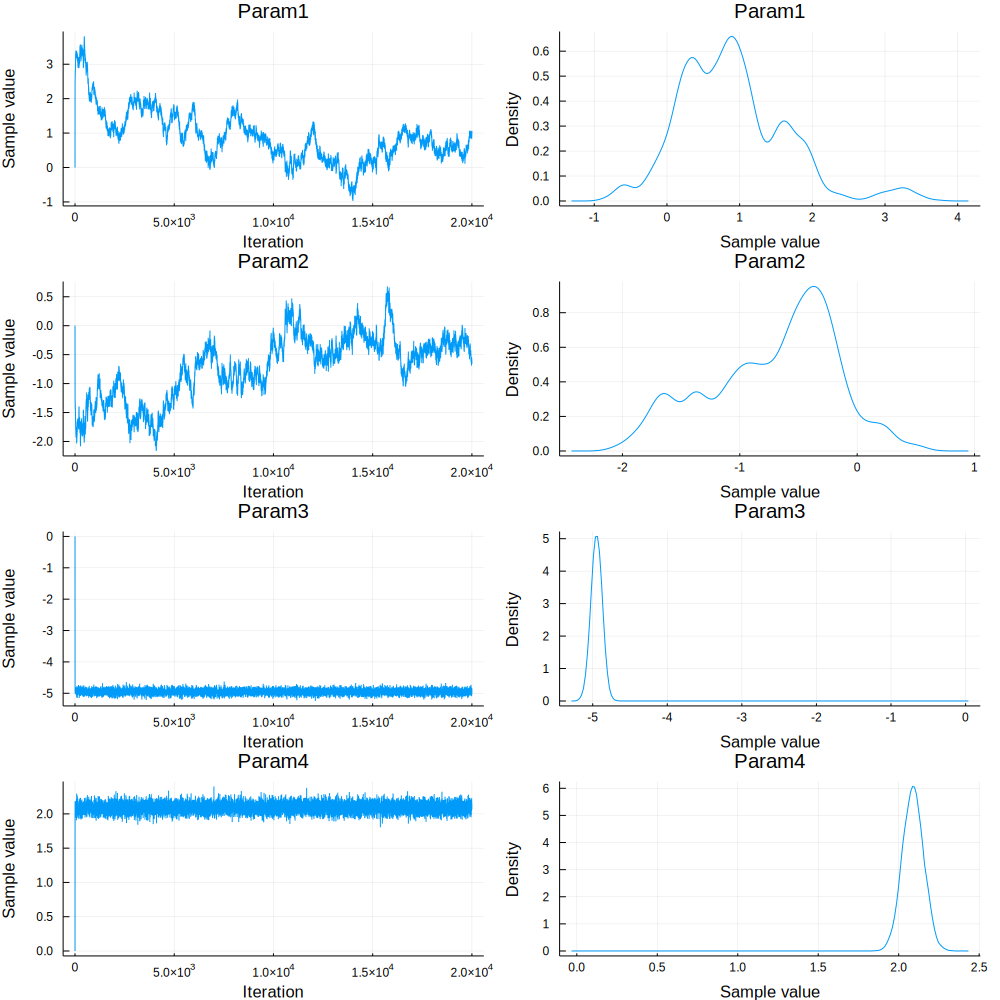

In [32]:
β_pos_sam = Array{Float64, 3}(undef, N_sam + 1, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[1, 1, :], γ_sam[1, 2, :], γ_sam[2, 1, :], γ_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

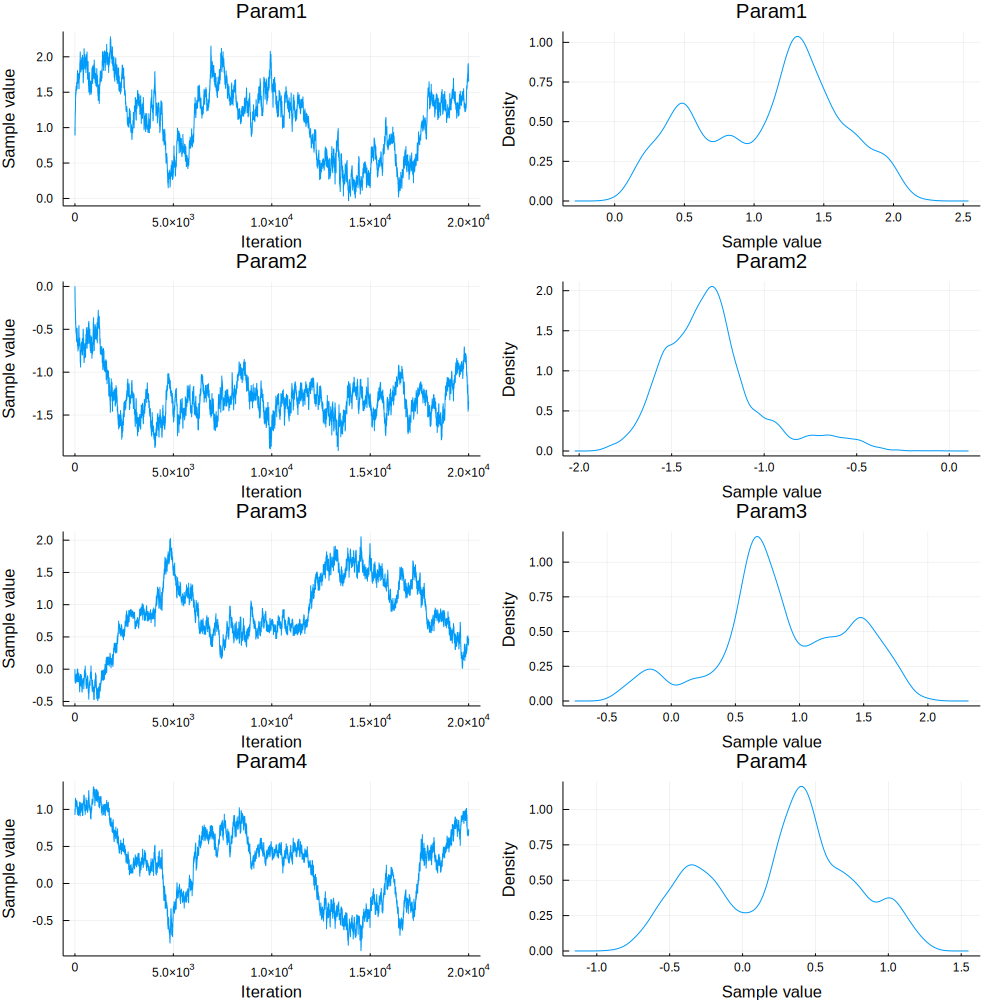

In [33]:
Λ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K * q, 1);
Λ_pos_sam[:, :, 1] = hcat(γ_sam[3, 1, :], γ_sam[3, 2, :], γ_sam[4, 1, :], γ_sam[4, 2, :]);
Λ_chain = Chains(Λ_pos_sam);
pΛ = plot(Λ_chain)

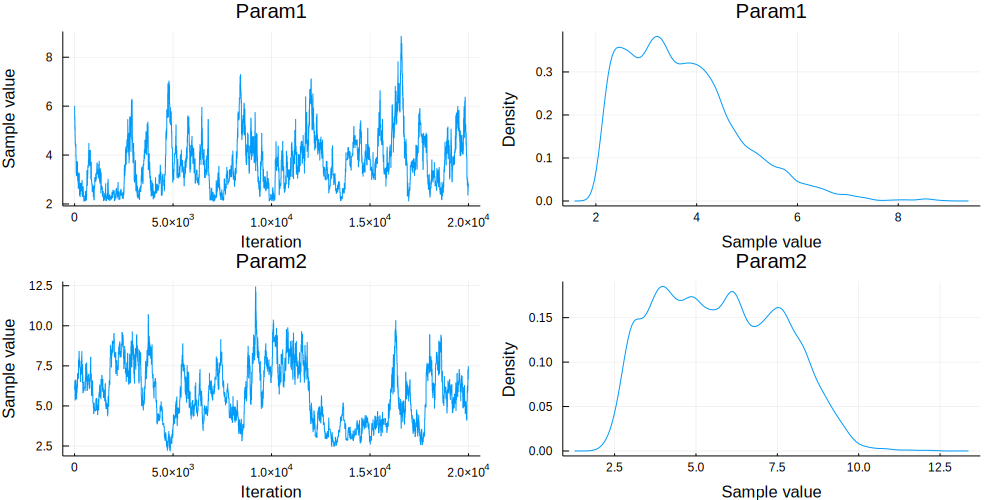

In [34]:
ϕ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, K, 1);
ϕ_pos_sam[:, :, 1] = hcat(ϕ_sam[1, :], ϕ_sam[2, :]);
ϕ_chain = Chains(ϕ_pos_sam);
pϕ = plot(ϕ_chain)

In [35]:
mean(A_sam)

0.4166235931006765

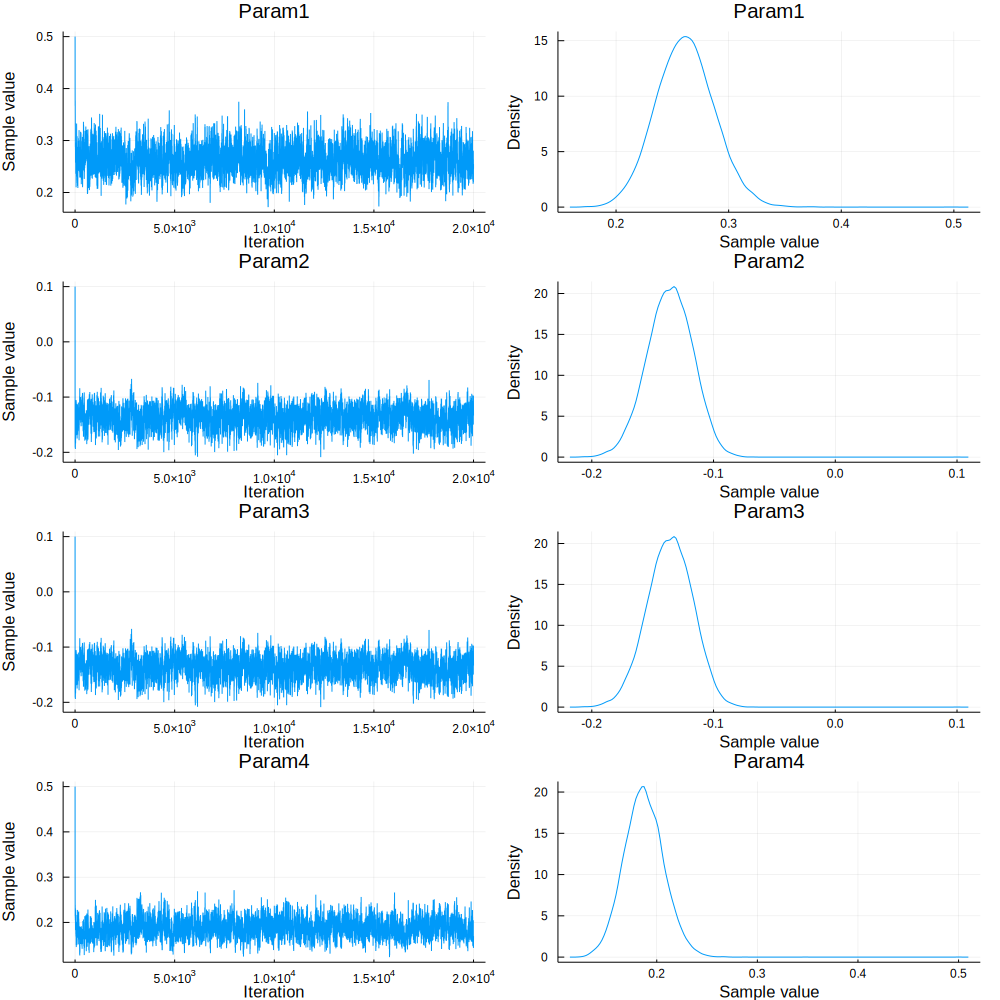

In [36]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, :], Σ_sam[1, 2, :], Σ_sam[2, 1, :], Σ_sam[2, 2, :]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

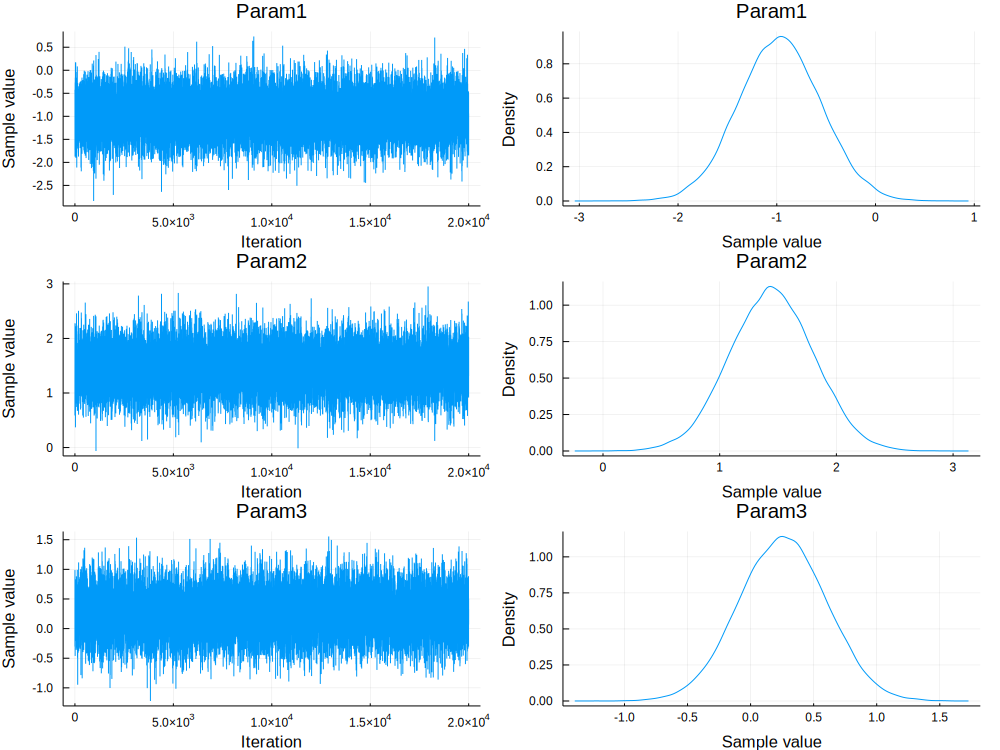

In [37]:
ω_incp_obs_pos_sam = Array{Float64, 3}(undef, n, q, N_sam);
lll = fill(1.0, (n, 1));
for i in 1:N_sam
    ω_incp_obs_pos_sam[:, :, i] = F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1] + 
                     lll * transpose(γ_sam[1, :, i + 1]);
end
truncindex = 1;#Integer(trunc(N_sam / 2));
ω_incp_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex  + 1, 3, 1);
ω_incp_pos_sam[:, :, 1] = hcat(ω_incp_obs_pos_sam[1, 1, truncindex:N_sam], 
    ω_incp_obs_pos_sam[1, 2, truncindex:N_sam], ω_incp_obs_pos_sam[200, 1, truncindex:N_sam]);
ω_incp_chain = Chains(ω_incp_pos_sam);
pΣ = plot(ω_incp_chain)

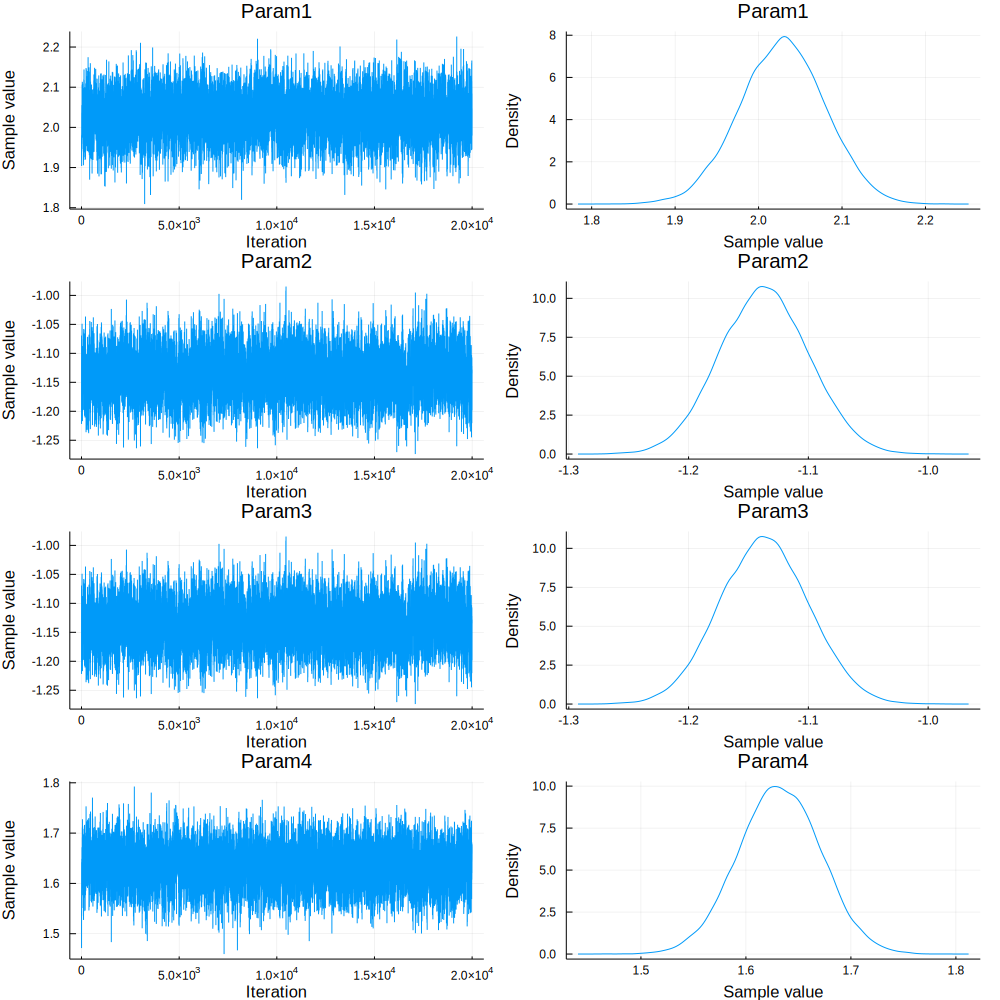

In [38]:
# check the variance covariance across latent process
cov_pos = Array{Float64, 3}(undef, q, q, N_sam);
for i in 1:N_sam
    cov_pos[:, :, i] = cov(F_sam[:, :, i] * γ_sam[(p + 1):(p + K), :, i + 1])
end   
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_pos[1, 1, :], cov_pos[1, 2, :], 
    cov_pos[2, 1, :], cov_pos[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

In [39]:
covω = cov(ω_ord[S, :])

2×2 Array{Float64,2}:
  2.11785  -1.18849
 -1.18849   1.66342

# Posterior Inference 

In [40]:
N_Inf_burn = Integer(trunc(0.75 * N_sam));
ω_incp_obs_pos_qt = Array{Float64, 3}(undef, n, q, 3);
for j in 1:q
    for i in 1:n
        ω_incp_obs_pos_qt[i, j, :] = quantile(ω_incp_obs_pos_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975])
    end
end
# count the covarage of 95% CI #
count_ω_incp = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω_incp[j] = count_ω_incp[j] + 
        ((ω_incp_obs_pos_qt[i, j, 1] < ω_incp_obs[S[i], j]) && 
            (ω_incp_obs_pos_qt[i, j, 3] > ω_incp_obs[S[i], j]))
    end
end
count_ω_incp

2-element Array{Float64,1}:
 949.0
 952.0

In [41]:
count_ω_incp ./ n

2-element Array{Float64,1}:
 0.949
 0.952

In [48]:
sum(count_ω_incp) / (2 * n)

0.9505

In [42]:
summary_table = Array{Float64, 2}(undef, (p - 1) * q + (q * q - 1) * 2 + q, 5);
summary_table[1, :] = vcat(β[2, 1], mean(γ_sam[2, 1, N_Inf_burn:(N_sam + 1)]),
    quantile(γ_sam[2, 1, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[2, 2], mean(γ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(γ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(Σ[1, 1], mean(Σ_sam[1, 1, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[1, 1, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(Σ[1, 2], mean(Σ_sam[1, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[1, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(Σ[2, 2], mean(Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)]),
    quantile(Σ_sam[2, 2, N_Inf_burn:(N_sam + 1)], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(covω[1, 1], mean(cov_pos_sam[N_Inf_burn:N_sam, 1, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 1, 1], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(covω[1, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 2, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 2, 1], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(covω[2, 2], mean(cov_pos_sam[N_Inf_burn:N_sam, 4, 1]),
    quantile(cov_pos_sam[N_Inf_burn:N_sam, 4, 1], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(ϕ1, mean(ϕ_sam[1, N_Inf_burn:N_sam]),
    quantile(ϕ_sam[1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(ϕ1, mean(ϕ_sam[2, N_Inf_burn:N_sam]),
    quantile(ϕ_sam[2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]", 
    "cov(ω)[1, 1]", "cov(ω)[1, 2]", "cov(ω)[2, 2]", "ϕ1", "ϕ2"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|              |   true |   mean | median |   2.5% |  97.5% |
|--------------|--------|--------|--------|--------|--------|
|      β[2, 1] |   -5.0 | -4.947 | -4.948 | -5.097 | -4.802 |
|      β[2, 2] |    2.0 |  2.089 |  2.089 |   1.96 |  2.216 |
|      Σ[1, 1] |    2.0 |  0.261 |   0.26 |  0.212 |  0.313 |
|      Σ[1, 2] |   -1.0 | -0.136 | -0.136 | -0.173 | -0.101 |
|      Σ[2, 2] |    1.5 |  0.187 |  0.186 |  0.151 |  0.226 |
| cov(ω)[1, 1] |  2.118 |  2.028 |  2.029 |  1.926 |  2.131 |
| cov(ω)[1, 2] | -1.188 | -1.135 | -1.135 | -1.207 | -1.062 |
| cov(ω)[2, 2] |  1.663 |  1.631 |  1.631 |  1.553 |  1.706 |
|           ϕ1 |    6.0 |  4.162 |  3.969 |  2.439 |  6.956 |
|           ϕ2 |    6.0 |  5.402 |  5.298 |  2.882 |  8.999 |


In [43]:
# posterior prediction check #
N_Inf_burn = 1;
Y_M_pos_qt = Array{Float64, 3}(undef, NM, q, 3);
Y_M_pos_mean = Array{Float64, 2}(undef, NM, q);
for j in 1:q
    for i in 1:NM
        Y_M_pos_qt[i, j, :] = quantile(Y_M_sam[i, j, :], [0.025, 0.5, 0.975]);
        Y_M_pos_mean[i, j] = mean(Y_M_sam[i, j, :])
    end
end
# count the covarage of 95% CI #
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        ((Y_M_pos_qt[i, j, 1] < Y_ord[M_ind[i], j]) && 
            (Y_M_pos_qt[i, j, 3] > Y_ord[M_ind[i], j]))
    end
end
count_Y_M

2-element Array{Float64,1}:
 188.0
 190.0

In [44]:
count_Y_M ./ NM

2-element Array{Float64,1}:
 0.94
 0.95

In [45]:
sum(count_Y_M) / (q * NM)

0.945

In [52]:
# calculate root mean square predictive error #
MSPE1 = mean((Y_ord[M, 1] - Y_M_pos_mean[:, 1]).^2)
RMSPE1 = sqrt(MSPE1); RMSPE1

0.7084872804187158

In [53]:
MSPE2 = mean((Y_ord[M, 2] - Y_M_pos_mean[:, 2]).^2)
RMSPE2 = sqrt(MSPE2); RMSPE2

0.6303274365542201

In [54]:
# calculate root mean square predictive error #
MSPE = (sum((Y_ord[M_ind, :] - Y_M_pos_mean).^2)) / (2 * 200)
RMSPE = sqrt(MSPE); RMSPE

0.6705471287643107

In [50]:
@save "../results/ω_incp_obs_pos_qt_BSLMC.jld"  ω_incp_obs_pos_qt